In [ ]:
# !pip install transformers

In [1]:
!mkdir weights
!mkdir data
!mkdir data/test
!mkdir data/queries

In [2]:
import numpy as np
import pandas as pd
import os
import shutil

In [3]:
train = pd.read_csv('../input/agrocode-data-science-cup-2022/train.csv')
test = train.sample(frac=0.01, random_state=41)
test.to_csv('./data/test.csv', index=False)
queries = train.sample(frac=0.01, random_state=42)
queries = queries[['idx']]
queries.to_csv('./data/queries.csv')

In [4]:
for idx in test['idx'].values:
    shutil.copy(f'../input/agrocode-data-science-cup-2022/train/train/{idx}.png', './data/test')
for idx in queries['idx'].values:
    shutil.copy(f'../input/agrocode-data-science-cup-2022/train/train/{idx}.png', './data/queries')

from:

https://huggingface.co/docs/transformers/model_doc/beit

In [5]:
# test one image
from transformers import BeitFeatureExtractor, BeitModel, BeitConfig
import torch
import cv2

configuration = BeitConfig()
configuration.use_mean_pooling = True

feature_extractor = BeitFeatureExtractor.from_pretrained("../input/beitbasepatch16224pt22k/feature_extractor/beit-base-patch16-224-pt22k_feature_extractor")
model = BeitModel.from_pretrained("../input/beitbasepatch16224pt22k/model/beit-base-patch16-224-pt22k_model", configuration)
# model.config

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
!cp -r ../input/beitbasepatch16224pt22k/feature_extractor/beit-base-patch16-224-pt22k_feature_extractor ./weights
!cp -r ../input/beitbasepatch16224pt22k/model/beit-base-patch16-224-pt22k_model ./weights

In [6]:
# model.save_pretrained('beit-base-patch16-224-pt22k_model')
# feature_extractor.save_pretrained('beit-base-patch16-224-pt22k_feature_extractor')

# !zip -r feature_extractor.zip ./beit-base-patch16-224-pt22k_feature_extractor
# !zip -r model.zip ./beit-base-patch16-224-pt22k_model

['beit-base-patch16-224-pt22k_feature_extractor/preprocessor_config.json']

In [47]:
from PIL import Image

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{queries.iloc[0,0]}.png'
img = Image.open(img_path).convert('RGB')
img = img.resize((224, 224))

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    
last_hidden_states = outputs.last_hidden_state  # last_hidden_state pooler_output

list(last_hidden_states[:, -1].shape)

[1, 768]

In [86]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

from PIL import Image


from transformers import BeitFeatureExtractor, BeitModel, BeitConfig
import torch

queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')

configuration = BeitConfig()
# configuration.use_mean_pooling = True

# feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
# model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k", configuration)


# feature_extractor = BeitFeatureExtractor.from_pretrained("./weights/beit-base-patch16-224-pt22k_feature_extractor")
# model = BeitModel.from_pretrained("./weights/beit-base-patch16-224-pt22k_model", configuration)

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
# model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k", configuration)
model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")

def extract_features(path, model=model):
#     img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))

    inputs = feature_extractor(img, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

#     feature = outputs.last_hidden_state[:, -1]
    feature = outputs.pooler_output
    
    feature = torch.squeeze(feature).numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))
    
queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k were not used when initializing BeitModel: ['lm_head.bias', 'layernorm.bias', 'layernorm.weight', 'lm_head.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.weight', 'beit.pooler.layernorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [87]:
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
6296,1.000000,4588
5654,0.989288,3447
373,0.988996,1782
4903,0.984959,1782
1045,0.984959,1782
7149,0.983926,3416
1805,0.983355,5998
4688,0.983109,6557
2035,0.983063,6557


In [90]:
idx_f = 6079
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
360,0.976889,225,6079
361,0.961319,5859,6079
362,0.955604,2607,6079
363,0.954254,1237,6079
364,0.952450,1708,6079
365,0.950633,7126,6079
366,0.949018,4422,6079
367,0.948207,1882,6079
368,0.946531,6073,6079
369,0.944622,1782,6079


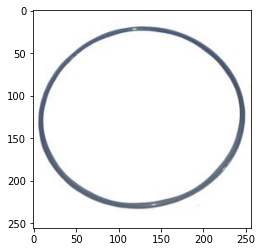

candidates:
score: [0.9768894]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


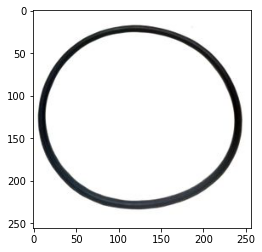

score: [0.961319]


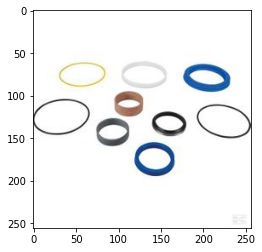

score: [0.9556043]


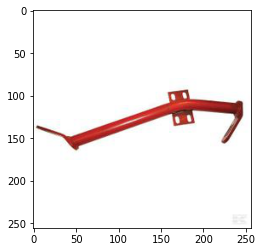

score: [0.95425415]


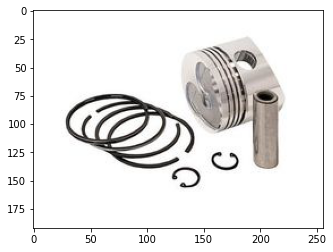

score: [0.9524498]


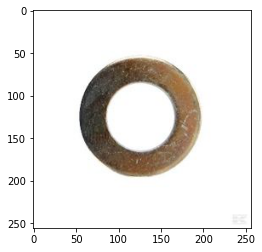

score: [0.9506333]


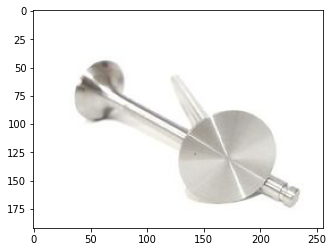

score: [0.949018]


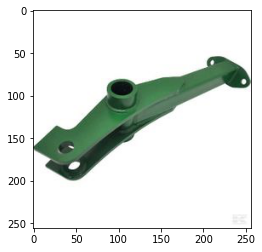

score: [0.948207]


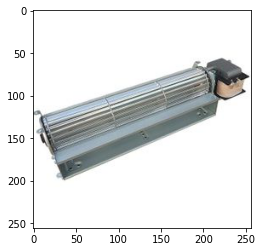

score: [0.946531]


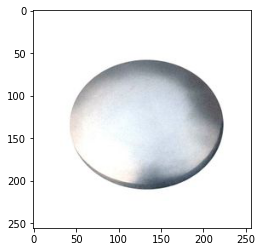

score: [0.94462204]


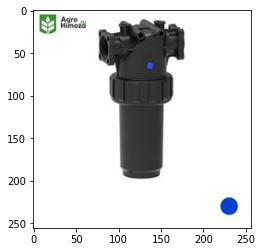

In [91]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'../input/agrocode-data-science-cup-2022/train/train/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{first_v}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{second_v}.png'
img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [ ]:
# distances

In [56]:
index_v = 2
first_v = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).index[index_v]
second_v = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).iloc[index_v, 1]
# second_v = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).index[4]]['database_idx'].iloc[2]

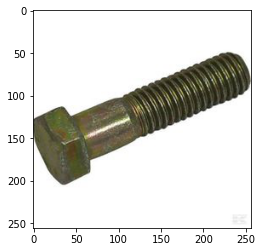

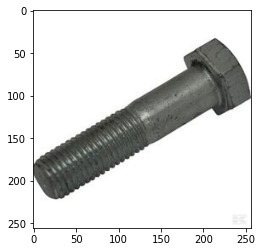

In [57]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{first_v}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{second_v}.png'
img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

CLIP model

In [100]:
# from transformers import CLIPProcessor, CLIPVisionModel

# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# model.save_pretrained('./clip-vit-base-patch32_model')
# processor.save_pretrained('./clip-vit-base-patch32_processor')

# !zip -r clip-vit-base-patch32_model.zip ./clip-vit-base-patch32_model
# !zip -r clip-vit-base-patch32_processor.zip ./clip-vit-base-patch32_processor

# !cp -r ./clip-vit-base-patch32_model ./weights
# !cp -r ./clip-vit-base-patch32_processor ./weights

  adding: clip-vit-base-patch32_model/ (stored 0%)
  adding: clip-vit-base-patch32_model/config.json (deflated 45%)
  adding: clip-vit-base-patch32_model/pytorch_model.bin (deflated 41%)
  adding: clip-vit-base-patch32_processor/ (stored 0%)
  adding: clip-vit-base-patch32_processor/special_tokens_map.json (deflated 73%)
  adding: clip-vit-base-patch32_processor/vocab.json (deflated 62%)
  adding: clip-vit-base-patch32_processor/merges.txt (deflated 60%)
  adding: clip-vit-base-patch32_processor/tokenizer.json (deflated 74%)
  adding: clip-vit-base-patch32_processor/tokenizer_config.json (deflated 59%)
  adding: clip-vit-base-patch32_processor/preprocessor_config.json (deflated 45%)


In [110]:
img_path = f'../input/agrocode-data-science-cup-2022/train/train/{queries.iloc[0,0]}.png'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
image = cv2.resize(img, (224, 224))

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

last_hidden_state.shape, pooled_output.shape

(torch.Size([1, 50, 768]), torch.Size([1, 768]))

In [116]:
pooled_output_norm = pooled_output / torch.linalg.norm(pooled_output)
# torch.mean(pooled_output), torch.std(pooled_output)
torch.mean(pooled_output_norm), torch.std(pooled_output_norm)

(tensor(0.0073, grad_fn=<MeanBackward0>),
 tensor(0.0354, grad_fn=<StdBackward0>))

In [101]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors


from transformers import CLIPProcessor, CLIPVisionModel
import torch

queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')


model = CLIPVisionModel.from_pretrained("./weights/clip-vit-base-patch32_model")
processor = CLIPProcessor.from_pretrained("./weights/clip-vit-base-patch32_processor")

# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


def extract_features(path, model=model):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    inputs = processor(images=img, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    feature = outputs.pooler_output
    
    feature = torch.squeeze(feature).numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))
    
queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [102]:
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
6296,1.000000,4588
5654,0.955080,4286
4494,0.930992,1251
6079,0.918217,225
3932,0.910976,4286
3834,0.905495,1006
4865,0.901207,3075
6546,0.899705,1251
4169,0.876061,225


In [107]:
idx_f = 5654
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
340,0.955080,4286,5654
341,0.927208,1006,5654
342,0.905993,3447,5654
343,0.877724,3042,5654
344,0.817488,7277,5654
345,0.812586,2985,5654
346,0.768018,6959,5654
347,0.759351,4422,5654
348,0.756358,1251,5654
349,0.748730,3075,5654


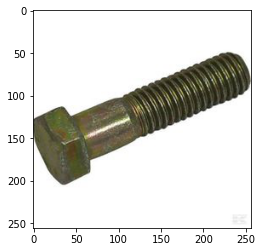

candidates:
score: [0.95507973]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


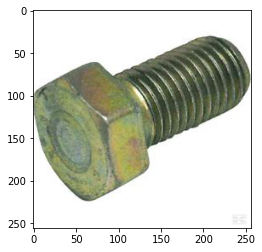

score: [0.92720795]


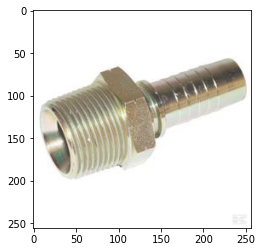

score: [0.90599275]


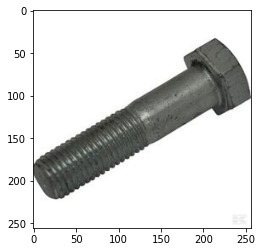

score: [0.8777237]


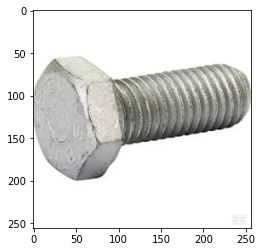

score: [0.8174877]


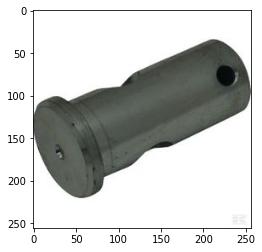

score: [0.81258553]


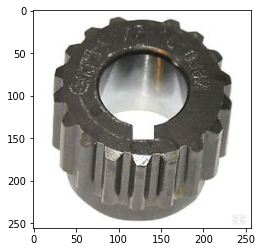

score: [0.76801753]


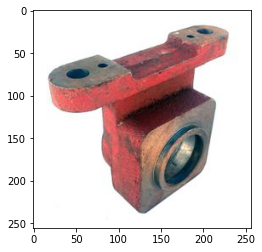

score: [0.7593515]


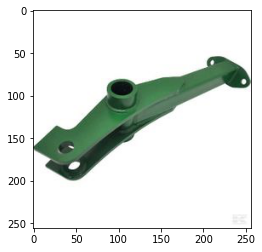

score: [0.75635827]


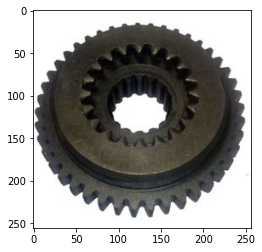

score: [0.74873024]


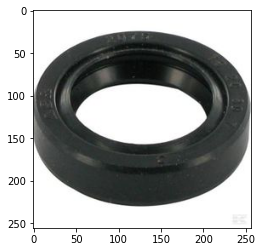

In [108]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'../input/agrocode-data-science-cup-2022/train/train/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()